In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import re
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91933\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91933\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
df = pd.read_csv("mail_data.csv") 

In [24]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [26]:
print('Initial shape:', df.shape)
df.dropna(inplace=True)
print('After dropping nulls:', df.shape)

Initial shape: (5572, 2)
After dropping nulls: (5572, 2)


In [8]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [27]:
# label spam mail as 1(true);  ham mail as 0(not spam - false);
encoder = LabelEncoder()
df['Category'] = encoder.fit_transform(df['Category'])
print('Label mapping:', dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Label mapping: {'ham': 0, 'spam': 1}


In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [29]:
def cleaning(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\.\S+', '', text)
    text = re.sub(r'[^a-z\s]','', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Message'] = df['Message'].apply(cleaning)

In [30]:
df['Message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                nah dont think go usf life around though
                              ...                        
5567    nd time tried contact u u pound prize claim ea...
5568                            b going esplanade fr home
5569                           pity mood soany suggestion
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: Message, Length: 5572, dtype: object

C:\Users\91933\AppData\Local\Temp\ipykernel_13152\4117347547.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=df, palette='Set2')


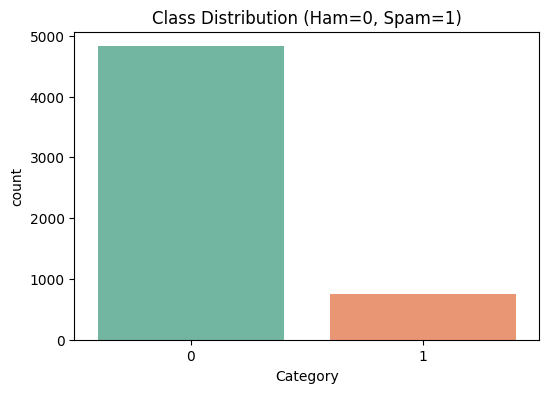

In [31]:
#EDA
plt.figure(figsize=(6,4))
sns.countplot(x='Category', data=df, palette='Set2')
plt.title('Class Distribution (Ham=0, Spam=1)')
plt.show()

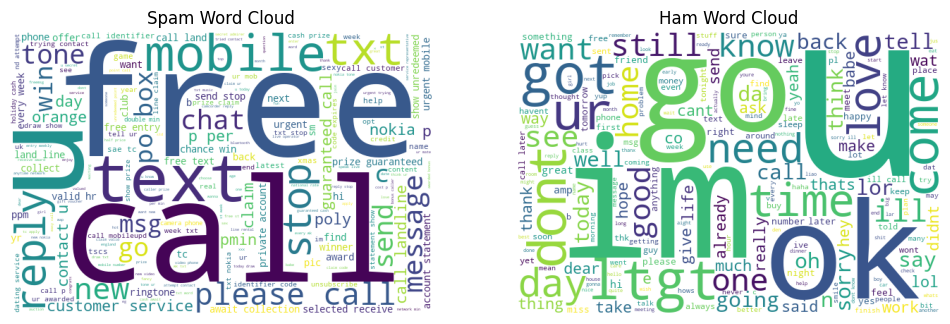

In [16]:
# WordClouds
spam_text = ' '.join(df[df['Category']==1]['Message'])
ham_text = ' '.join(df[df['Category']==0]['Message'])


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(spam_text))
plt.title('Spam Word Cloud')
plt.axis('off')


plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color='white').generate(ham_text))
plt.title('Ham Word Cloud')
plt.axis('off')
plt.show()

In [32]:
# separating the data as texts and label

X = df['Message']
Y = df['Category']

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)

In [20]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(5572,)
(3900,)
(1672,)


In [34]:
X_train

1455                  decide faster co si going home liao
3460    heard u call night knickers make beg like u la...
2493    drama plsi enough family struggling hot sun st...
3378    yup wun believe wat u really neva c e msg sent...
3826    hi im always online yahoo would like chat someday
                              ...                        
789     free top polyphonic tone call national rate ge...
968     u want come backa beautiful necklace token hea...
1667      guess spent last night phasing fourth dimension
3321    eh sorry leh din c ur msg sad already lar watc...
1688    free top ringtone sub weekly ringtoneget st we...
Name: Message, Length: 3900, dtype: object

### Feature Extraction

In [21]:
# transform the text data to feature vectors that can be used as input to the Logistic regression

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000, stop_words='english', lowercase=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [35]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 31508 stored elements and shape (3900, 5000)>

In [22]:
X_train_dense = X_train_tfidf.toarray()
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_dense, Y_train)

In [37]:
X_train_dense
X_train_dense.shape

(3900, 5000)

In [38]:
print("Before SMOTE:", Counter(Y_train))
print("After SMOTE:", Counter(y_train_sm))

Before SMOTE: Counter({0: 3385, 1: 515})
After SMOTE: Counter({0: 3385, 1: 3385})


In [39]:
models = {
'Logistic Regression': LogisticRegression(max_iter=1000),
'Naive Bayes': MultinomialNB(),
'SVM (Linear)': LinearSVC()
}


results = {}


for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    preds = model.predict(X_test_tfidf)
    acc = accuracy_score(Y_test, preds)
    results[name] = acc
    print(f'\n===== {name} =====')
    print('Classification Report:\n', classification_report(Y_test, preds))
    # disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, preds), display_labels=['Ham','Spam'])
    # disp.plot(cmap='Blues')
    # plt.title(f'Confusion Matrix - {name}')
    # plt.show()


===== Logistic Regression =====
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1440
           1       0.87      0.92      0.90       232

    accuracy                           0.97      1672
   macro avg       0.93      0.95      0.94      1672
weighted avg       0.97      0.97      0.97      1672


===== Naive Bayes =====
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1440
           1       0.87      0.93      0.90       232

    accuracy                           0.97      1672
   macro avg       0.93      0.95      0.94      1672
weighted avg       0.97      0.97      0.97      1672


===== SVM (Linear) =====
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1440
           1       0.75      0.93      0.83       232

    accuracy              

                 Model  Accuracy
1          Naive Bayes  0.971292
0  Logistic Regression  0.970694
2         SVM (Linear)  0.946172


C:\Users\91933\AppData\Local\Temp\ipykernel_13152\4214977072.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=result_df, palette='viridis')


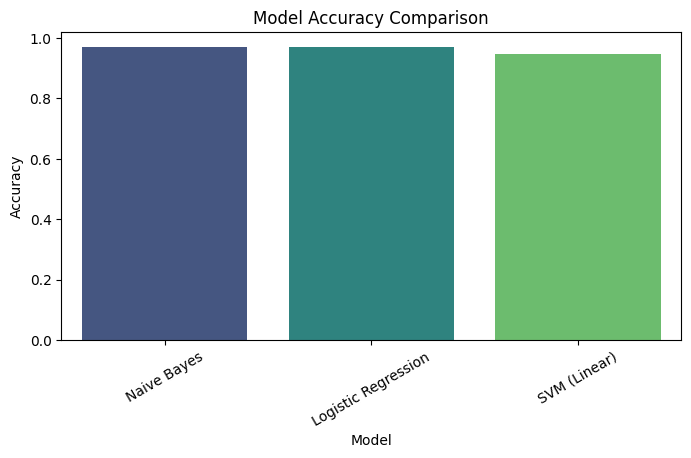

In [40]:
result_df = pd.DataFrame(list(results.items()), columns=['Model','Accuracy']).sort_values(by='Accuracy', ascending=False)
print(result_df)

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='Accuracy', data=result_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=30)
plt.show()

### Building a Predictive System

In [41]:
#sample example
sample_mail = ["Congratulations! You've won a free iPhone. Click here to claim.",
"Hey, are we still meeting for lunch tomorrow?"]

sample_features = vectorizer.transform(sample_mail)

sample_preds = models['Naive Bayes'].predict(sample_features)

for mail, label in zip(sample_mail, sample_preds):
  print(f'\nMail: {mail}\nPrediction: {"Spam" if label==1 else "Ham"}')


Mail: Congratulations! You've won a free iPhone. Click here to claim.
Prediction: Spam

Mail: Hey, are we still meeting for lunch tomorrow?
Prediction: Ham


For this project, the goal is to minimize false positives — ensuring that legitimate emails are not incorrectly marked as spam. Therefore, Logistic Regression was chosen as the final model because it offers high precision, interpretable results, and the flexibility to adjust the decision threshold using predicted probabilities. Unlike Naive Bayes, which assumes strong feature independence, Logistic Regression can better capture correlations between words, leading to more reliable classifications. It also trains quickly on TF-IDF data, making it both efficient and well-suited for a precision-focused spam filtering system.

In [43]:
import pickle

# Save the best model and vectorizer
pickle.dump(models['Logistic Regression'], open('spam_model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!
